# **Classification of Skin Cancer using Convolutional Neural Network (CNN)**

# **Loading Important Packages**

In [1]:
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Convolution2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical
from matplotlib import pyplot as plt
import tensorflow as tf
import random
import seaborn as sns
import pandas as pd
import numpy as np
import cv2,os
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score


In [2]:
data_dir="Skin cancer dataset"

In [3]:
diseases=[]
for file in os.listdir(data_dir):
    diseases+=[file]
print(diseases)
print(len(diseases))

['benign', 'malignant']
2


In [4]:
train_dir = os.path.join(data_dir)


In [5]:
train_data = []
for defects_id, sp in enumerate(diseases):
    for file in os.listdir(os.path.join(data_dir, sp)):
        train_data.append(['{}/{}'.format(sp, file), defects_id, sp])

train = pd.DataFrame(train_data, columns=['File', 'LabelID', 'Label'])
train.head()

,File,LabelID,Label
0,benign/1.jpg,0,benign
1,benign/10.jpg,0,benign
2,benign/100.jpg,0,benign
3,benign/1000.jpg,0,benign
4,benign/1001.jpg,0,benign


In [6]:
SEED = 42
train = train.sample(frac=1, random_state=SEED)
train.index = np.arange(len(train))  # Reset indices
train.tail()


,File,LabelID,Label
3292,benign/364.jpg,0,benign
3293,benign/396.jpg,0,benign
3294,benign/543.jpg,0,benign
3295,benign/1773.jpg,0,benign
3296,malignant/889.jpg,1,malignant


In [7]:
def plot_defects(defect_types, rows, cols):
    fig, ax = plt.subplots(rows, cols, figsize=(8, 8))
    defect_files = train['File'][train['Label'] == defect_types].values
    n = 0
    for i in range(rows):
        for j in range(cols):
            image_path = os.path.join(data_dir, defect_files[n])
            ax[i, j].set_xticks([])
            ax[i, j].set_yticks([])
            ax[i, j].imshow(cv2.imread(image_path))
            n += 1




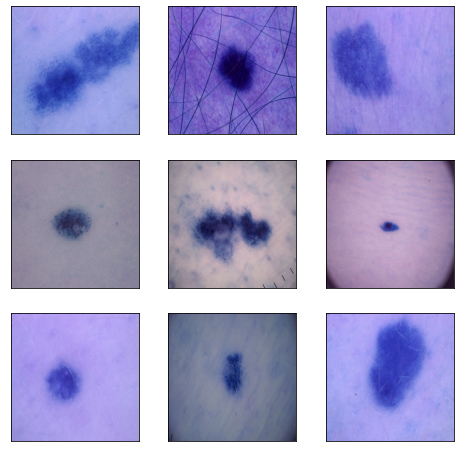

In [8]:
plot_defects('benign', 3, 3)

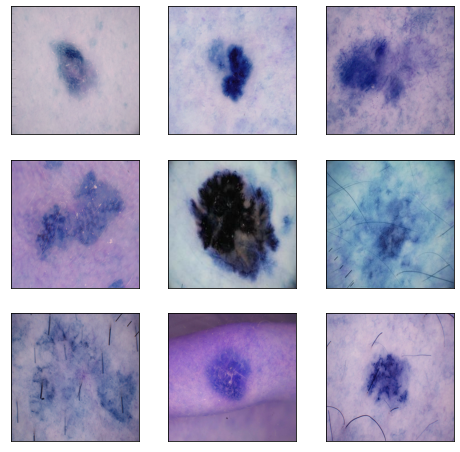

In [9]:
plot_defects('malignant', 3, 3)

# **Data Augmentation**

In [10]:
train_datagen = ImageDataGenerator(rescale=1. / 255,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True)
                                   
test_datagen = ImageDataGenerator(rescale=1. / 255)

training_set = train_datagen.flow_from_directory(data_dir,
                                                 target_size=(64,64),
                                                 batch_size=12,
                                                 class_mode='categorical'
                                                 )


Found 3297 images belonging to 2 classes.


In [11]:
IMAGE_SIZE = 64


def read_image(filepath):
    return cv2.imread(os.path.join(data_dir, filepath))


def resize_image(image, image_size):
    return cv2.resize(image.copy(), image_size, interpolation=cv2.INTER_AREA)


x_train = np.zeros((train.shape[0], IMAGE_SIZE, IMAGE_SIZE, 3))
for i, file in tqdm(enumerate(train['File'].values)):
    image = read_image(file)
    if image is not None:
        x_train[i] = resize_image(image, (IMAGE_SIZE, IMAGE_SIZE))
        
x_train = x_train / 255.

num_classes=2
y_train = train['LabelID'].values
y_train = to_categorical(y_train,num_classes)

X_train, X_test, Y_train, Y_test = train_test_split(x_train, y_train, test_size=0.3, random_state=SEED)
print('Train Shape: {}'.format(X_train.shape))
print('Train Shape: {}'.format(Y_train.shape))

0it [00:00, ?it/s]

3297it [00:27, 119.15it/s]


Train Shape: (2307, 64, 64, 3)
Train Shape: (2307, 2)


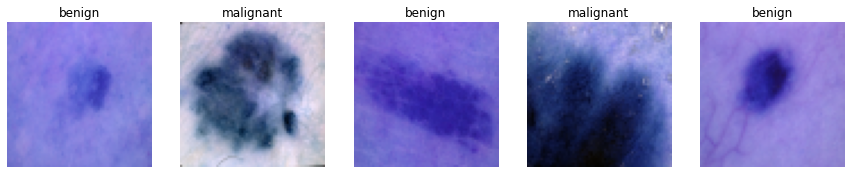

In [12]:
fig, ax = plt.subplots(1, 5, figsize=(15, 15))
for i in range(5):
    ax[i].set_axis_off()
    ax[i].imshow(X_train[i])
    ax[i].set_title(diseases[np.argmax(Y_train[i])])

# **CNN Model Building**

In [13]:
classifier = Sequential()

# 1st model

classifier.add(Convolution2D(512, (3, 3), input_shape=(64, 64, 3), activation='relu',strides=(3,3)))

classifier.add(MaxPooling2D(pool_size=(3, 3)))

classifier.add(Convolution2D(256, (2, 2), activation='relu'))

classifier.add(MaxPooling2D(pool_size=(1, 1)))

classifier.add(Flatten())

classifier.add(Dense(units=64, activation='relu'))

classifier.add(Dense(units=2, activation='softmax'))
classifier.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 21, 21, 512)       14336     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 7, 7, 512)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 6, 6, 256)         524544    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 6, 6, 256)         0         
_________________________________________________________________
flatten (Flatten)            (None, 9216)              0         
_________________________________________________________________
dense (Dense)                (None, 64)                589888    
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 1

# **Model Compilation and Training**

In [14]:
classifier.compile(optimizer="adam",loss="categorical_crossentropy",metrics=['accuracy',tf.keras.metrics.Precision(),tf.keras.metrics.Recall(),tf.keras.metrics.FalseNegatives(),tf.keras.metrics.FalsePositives()])
history = classifier.fit(X_train,Y_train,epochs=25,batch_size=10,validation_data=(X_test,Y_test))

Epoch 1/25
231/231 [==============================] - 14s 48ms/step - loss: 0.5953 - accuracy: 0.6732 - precision: 0.6732 - recall: 0.6732 - false_negatives: 754.0000 - false_positives: 754.0000 - val_loss: 0.4530 - val_accuracy: 0.7889 - val_precision: 0.7889 - val_recall: 0.7889 - val_false_negatives: 209.0000 - val_false_positives: 209.0000
Epoch 2/25
231/231 [==============================] - 11s 47ms/step - loss: 0.4702 - accuracy: 0.7672 - precision: 0.7672 - recall: 0.7672 - false_negatives: 537.0000 - false_positives: 537.0000 - val_loss: 0.4103 - val_accuracy: 0.8000 - val_precision: 0.8000 - val_recall: 0.8000 - val_false_negatives: 198.0000 - val_false_positives: 198.0000
Epoch 3/25
231/231 [==============================] - 11s 49ms/step - loss: 0.4355 - accuracy: 0.7820 - precision: 0.7820 - recall: 0.7820 - false_negatives: 503.0000 - false_positives: 503.0000 - val_loss: 0.3846 - val_accuracy: 0.8111 - val_precision: 0.8111 - val_recall: 0.8111 - val_false_negatives: 187

# **Model Saving**

In [15]:
classifier.evaluate(X_test,Y_test)
classifier.save("models/CNNModel.h5")

31/31 [==============================] - 1s 25ms/step - loss: 0.3824 - accuracy: 0.8374 - precision: 0.8374 - recall: 0.8374 - false_negatives: 161.0000 - false_positives: 161.0000


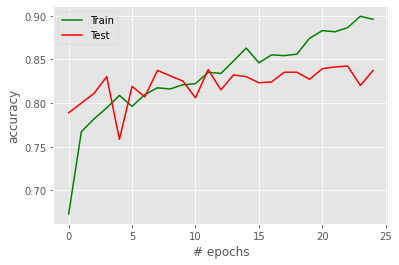

In [16]:
plt.style.use("ggplot")
plt.figure()
plt.plot(history.history['accuracy'],'r',label='Training Accuracy',color='green')
plt.plot(history.history['val_accuracy'],label='Validation Accuracy',color='red')
plt.xlabel('# epochs')
plt.ylabel('accuracy')
plt.legend(['Train', 'Test'], loc='upper left')
plt.savefig("models/CNNModel_accuracy.png")
plt.show()



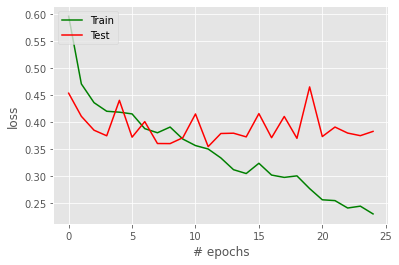

In [17]:
plt.style.use("ggplot")
plt.figure()
plt.plot(history.history['loss'],'r',label='Training loss',color='green')
plt.plot(history.history['val_loss'],label='Validation loss',color='red')
plt.xlabel('# epochs')
plt.ylabel('loss')
plt.legend(['Train', 'Test'], loc='upper left')
plt.savefig("models/CNNModel_Loss.png")
plt.show()

